In [1]:
from poloniex import Poloniex
from tusp import string2ts, ts2string
import json
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

polo = Poloniex()

# historyData es una lista de diccionarios python
# candlestick period in seconds; valid values are 300, 900, 1800, 7200, 14400, and 86400
historyData = polo.returnChartData(currencyPair="BTC_ETC",
                     start=string2ts("2017-01-01 00:00:00"),
                     end=string2ts("2017-05-01 00:00:00"),
                     period=3600*4)

# Guardando los datos como lista de diccionarios en un archivo de texto
# esto permite acceder a ellos y trabajar como data frame offline
with open("XMR_data.out","w") as f:
    json.dump(historyData,f)
    
with open("XMR_data.out") as f:
    historyData = json.load(f)
    #print data

# convirtiendo datos en data frame
df = pd.DataFrame(historyData)

#  convirtiendo string a float o int
df["close"] =pd.to_numeric(df['close'])
df["open"] =pd.to_numeric(df['open'])
df["low"] =pd.to_numeric(df['high'])
df["volume"] =pd.to_numeric(df['volume'])
df["date"] = pd.to_datetime(df["date"].apply(ts2string))
df["weightedAverage"] =pd.to_numeric(df['weightedAverage'])

# seleccionando la columna de fecha como indice
df = df.set_index("date")

# examinando las primeras filas
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-01-01 03:00:00,0.001476,0.0015371,0.001537,0.001520,99984.03526958,149.494761,0.001495
2017-01-01 07:00:00,0.001487,0.00149799,0.001498,0.001484,77637.68927979,114.388095,0.001473
2017-01-01 11:00:00,0.001383,0.00149499,0.001495,0.001487,524329.3144906,733.365885,0.001399
2017-01-01 15:00:00,0.001394,0.00139998,0.001400,0.001383,188164.8416986,257.332003,0.001368
2017-01-01 19:00:00,0.001365,0.0014259,0.001426,0.001394,338577.23733602,464.734635,0.001373


# Calculando retornos, log retornos y sus respectivos acumulados

Retorno final del mercado: 234.399745307


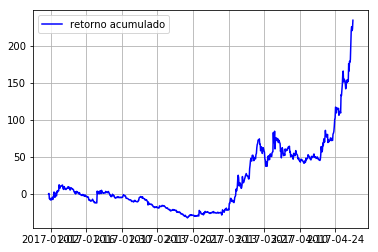

In [2]:
# Calculando retornos relativos
# el 1 se refiere al numero de periodos que se toma para calcular el cambio porcentual
df["retornos relativos"] = df["close"].pct_change(1).fillna(0)

# calculando los log retornos
df["log retornos"] = np.log(df["close"]).diff().fillna(0)

# calculando log retorno acumulado
df["cum_logr"] = df["log retornos"].cumsum()
df["cum_r"] = np.exp(df["cum_logr"]) - 1

#plt.plot(df.index,df['cum_logr']*100,'r',label='log retorno acumulado')
plt.plot(df.index,df['cum_r']*100,'b', label='retorno acumulado')
plt.legend()
plt.grid()
#df.isnull().any()
#df[df['retornos relativos'].isnull()]
print "Retorno final del mercado: %s"%(df["cum_r"][-1]*100)

# Ejemplo estrategía, media movil

Las estrategías funcionan como funciones que como parámetro reciben una serie de pandas o una lista de tamaño $T$ (intervalo de tiempo de estudio divido en el periodo de interés), y devuelven el vector de pesos $\vec{w}$ de tamaño $T\times 2$ y que contiene solo ceros o unos (1 si se posee el determinado activo, 0 si no). La primera columna de $\vec{w}$ corresponde a la posesión del activo de interés, la segunda a la posesión de la moneda por la que se tranza (generalmente **BTC**) 

El retorno con la estrategia EMA_5 vs SMA_20 fue 140.036116418


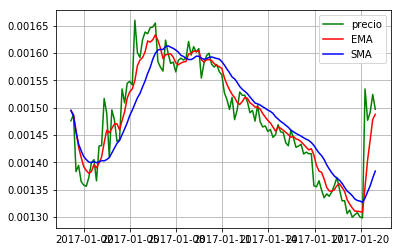

In [3]:
from profit import profit,change5, profit2
from orders import orders

# dada una serie de pandas o una lista y el numero de muestras para la EMA y SMA devuelve vector w
# considerando el cruce entre EMA y SMA
def estrategiaEMAvsSMA(serie, smaPeriod=20,emaPeriod=5):
    
    # Calculando media movil a 20 muestras
    sma = serie.rolling(smaPeriod,min_periods=1).mean()
    # caculando exponential movil average
    ema = serie.ewm(span=emaPeriod, adjust=False).mean()
    
    # Encontrando el signo de la resta entre ellas para encontrar los cruces
    dif = (ema - sma).apply(np.sign)
    
    w = pd.DataFrame(data={"w":(dif+1)/2})
    
    w['w'] = w['w'].apply(change5)
    
    w["orders"] = orders(w["w"])
    w['w'] = w['w'].shift(1)
    w["price"] = serie
    
    plt.plot(df.index[:120],df['close'][:120],'g',label='precio')
    plt.plot(df.index[:120],ema[:120],'r',label='EMA')
    plt.plot(df.index[:120],sma[:120],'b',label='SMA')
    plt.legend(loc='best')
    plt.grid()
    
    return w



w = estrategiaEMAvsSMA(df['weightedAverage'],13,5)
relativeReturn, vecReturn = profit(w)

#relativeReturn2, vecReturn2 = profit2(w,1.0)

print 'El retorno con la estrategia EMA_5 vs SMA_20 fue %s'%(vecReturn[-1]*100)

w["return1"] = vecReturn
#print w.loc["2017-06-01 03:00:00":"2017-06-02 07:00:00",["orders","price","btc_balance","coin_balance","balance"]]
#print w[w["orders"]!="WAIT"][["orders","balance","btc_balance","coin_balance","price"]][:15]
#print w[["orders","w","return1","price"]][:15]

In [4]:
from strategy import pricevsEMA, pricevsSMA, EMAvsEMA

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'],5)
relativeReturn2,v2 = profit(w2)

#Precio vs SMA_20

w3 = pricevsSMA(df['weightedAverage'])
relativeReturn3,v3 = profit(w3)

print 'El retorno relativo con la estrategia precio VS SMA20 fue: %s'%(relativeReturn3*100)
print 'El retorno relativo con la estrategia Precio VS EMA5 fue: %s'%(relativeReturn2*100)

El retorno relativo con la estrategia precio VS SMA20 fue: 237.418386621
El retorno relativo con la estrategia Precio VS EMA5 fue: 159.340035706


Graficand los retornos de un par de estrategías y el comportamiento del precio

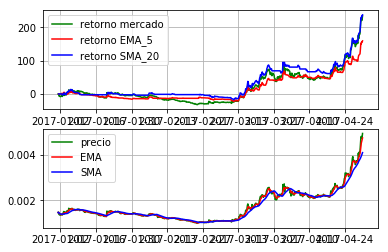

In [5]:
# Calculando media movil a 20 muestras
sma = df["close"].rolling(20,min_periods=1).mean()
# caculando exponential movil average
ema = df["close"].ewm(span=5, adjust=False).mean()

plt.subplot(211)
plt.plot(df.index,df['cum_r']*100,'g', label='retorno mercado')
plt.plot(df.index,v2*100,'r',label='retorno EMA_5')
plt.plot(df.index,v3*100,'b',label='retorno SMA_20')
plt.legend(loc='best')
plt.grid()

plt.subplot(212)
plt.plot(df.index,df['close'],'g',label='precio')
plt.plot(df.index,ema,'r',label='EMA')
plt.plot(df.index,sma,'b',label='SMA')
plt.legend(loc='best')
plt.grid()

# Agregando RSI via Stockstacks

En primera instancia, la idea es calcular el RSI y utilizarlo para mejorar la estrategia de las medias móviles. 

/home/daniel/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,close,high,low,open,quotevolume,volume,weightedaverage,retornos relativos,log retornos,cum_logr,cum_r,close_-1_s,close_-1_d,rs_14,rsi_14
date,,,,,,,,,,,,,,,
2017-01-01 03:00:00,0.001476,0.0015371,0.001537,0.001520,99984.03526958,149.494761,0.001495,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2017-01-01 07:00:00,0.001487,0.00149799,0.001498,0.001484,77637.68927979,114.388095,0.001473,0.007458,0.007430,0.007430,0.007458,0.001476,0.000011,inf,100.000000
2017-01-01 11:00:00,0.001383,0.00149499,0.001495,0.001487,524329.3144906,733.365885,0.001399,-0.069925,-0.072490,-0.065060,-0.062989,0.001487,-0.000104,0.098304,8.950492
2017-01-01 15:00:00,0.001394,0.00139998,0.001400,0.001383,188164.8416986,257.332003,0.001368,0.008089,0.008057,-0.057003,-0.055409,0.001383,0.000011,0.214176,17.639641
2017-01-01 19:00:00,0.001365,0.0014259,0.001426,0.001394,338577.23733602,464.734635,0.001373,-0.021148,-0.021374,-0.078378,-0.075385,0.001394,-0.000029,0.161173,13.880190


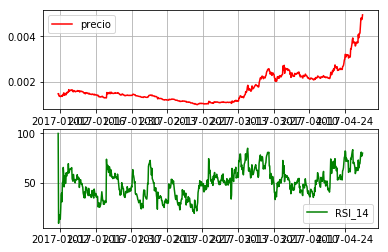

In [6]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())

stock["rsi_14"]

plt.subplot(211)
plt.plot(df.index,df['close'],'r', label='precio')
plt.legend(loc='best')
plt.grid()

plt.subplot(212)
plt.plot(df.index,stock["rsi_14"],'g',label='RSI_14')
plt.legend(loc='best')
plt.grid()

stock.head()

# Calculando maximos y minimos, generando vector w con estos.

Usando [peakdetect](https://gist.github.com/sixtenbe/1178136#file-peakdetect-py)

/home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/daniel/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/daniel/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


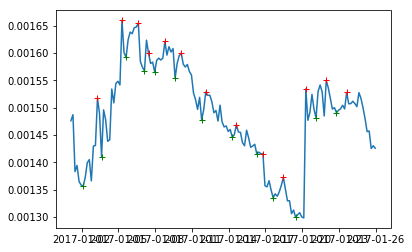

In [7]:
from peakdetect import peakdetect

y = df['close'][:150].values
x = df.index[:150].values

_max, _min = peakdetect(y, x, 3)

xm = [p[0] for p in _max]
ym = [p[1] for p in _max]
xn = [p[0] for p in _min]
yn = [p[1] for p in _min]

plot = plt.plot(x, y)
plt.hold(True)
plt.plot(xm, ym, "r+")
plt.plot(xn, yn, "g+")


mldata.py:24: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)


11606.6412507


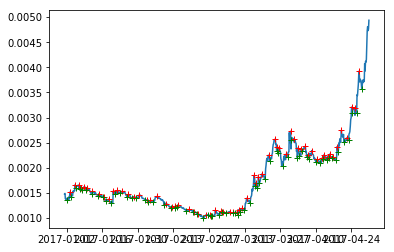

In [8]:
# probando ml_data
from mldata import ml_data

df["ml_data2"] = ml_data(df["close"])

w4 = pd.DataFrame(data={"w":df["ml_data2"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print relReturn*100
strategys = pd.DataFrame(data={"sma20ema5":w["orders"],"price_sma20":w3["orders"],"price_ema5":w2["orders"],"max_min":w4["orders"]})
#print df.loc["2017-06-03 03:00:00":"2017-06-09 07:00:00",["close","min_max","ml_data","ml_data2"]]